In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import gradio as gr

In [ ]:
data = pd.read_excel(
    "/20251111_JUNCTION_training.xlsx",
    sheet_name="training_consumption",
    header=0,
    index_col=0
)

# if the file was read with customer groups as a single row (headers moved to row), transpose
if data.shape[0] == 1 and data.shape[1] > 1:
    data = data.T

# try to convert the index to datetime (timestamps)
try:
    data.index = pd.to_datetime(data.index)
except Exception:
    pass

# restrict to last 1 year based on the latest timestamp in the index
last_ts = data.index.max()
cutoff = last_ts - pd.DateOffset(years=1)
data = data.loc[data.index >= cutoff]

Running SARIMA fits in parallel on 112 columns using all CPU cores (n_jobs=-1).
Reminder: statsmodels SARIMAX does not use GPU. If you require GPU-accelerated time series models, consider deep-learning alternatives (Prophet/ARIMA variants generally CPU).


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of 112 | elapsed:  3.6min remaining: 27.5min
[Parallel(n_jobs=-1)]: Done  36 out of 112 | elapsed:  8.3min remaining: 17.6min
[Parallel(n_jobs=-1)]: Done  59 out of 112 | elapsed: 12.7min remaining: 11.4min
[Parallel(n_jobs=-1)]: Done  82 out of 112 | elapsed: 17.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done 105 out of 112 | elapsed: 21.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 22.9min finished


Fitted: 112 models, Failed: 0 models


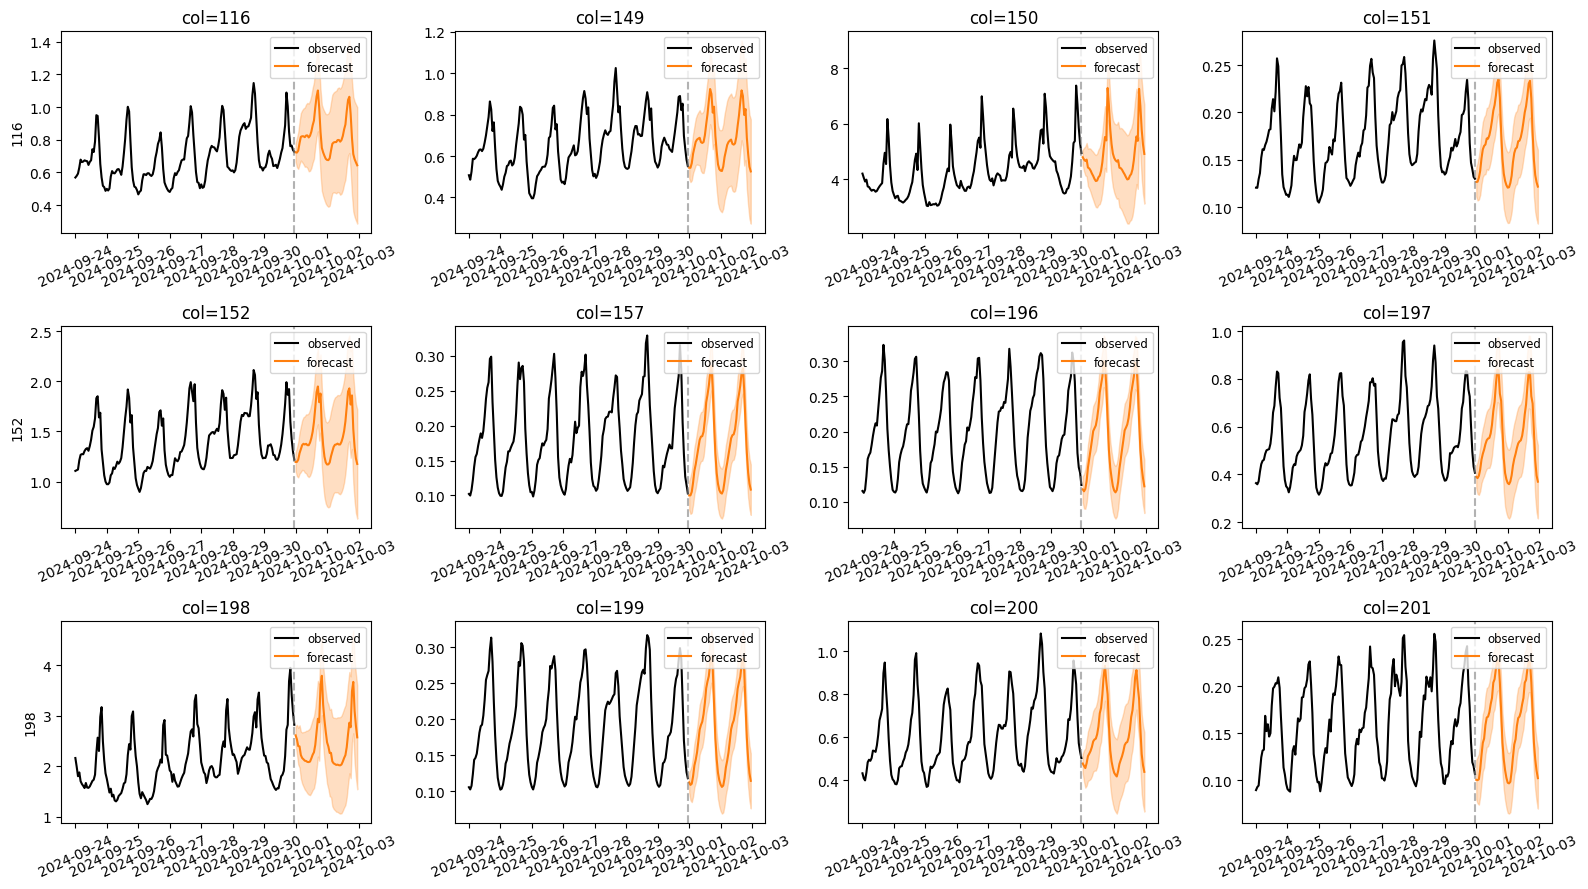

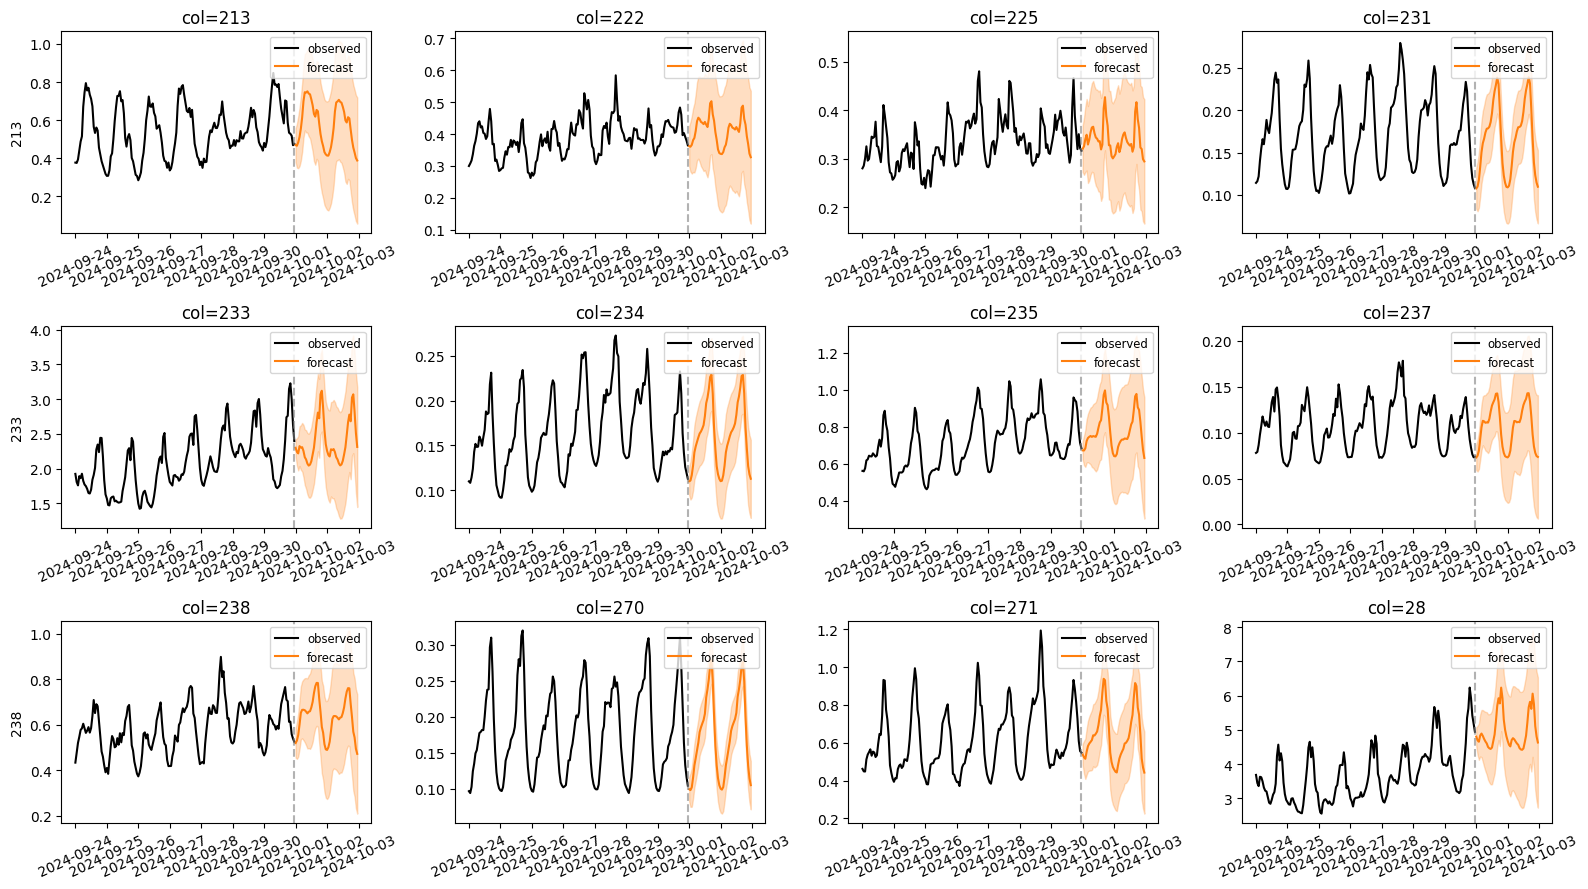

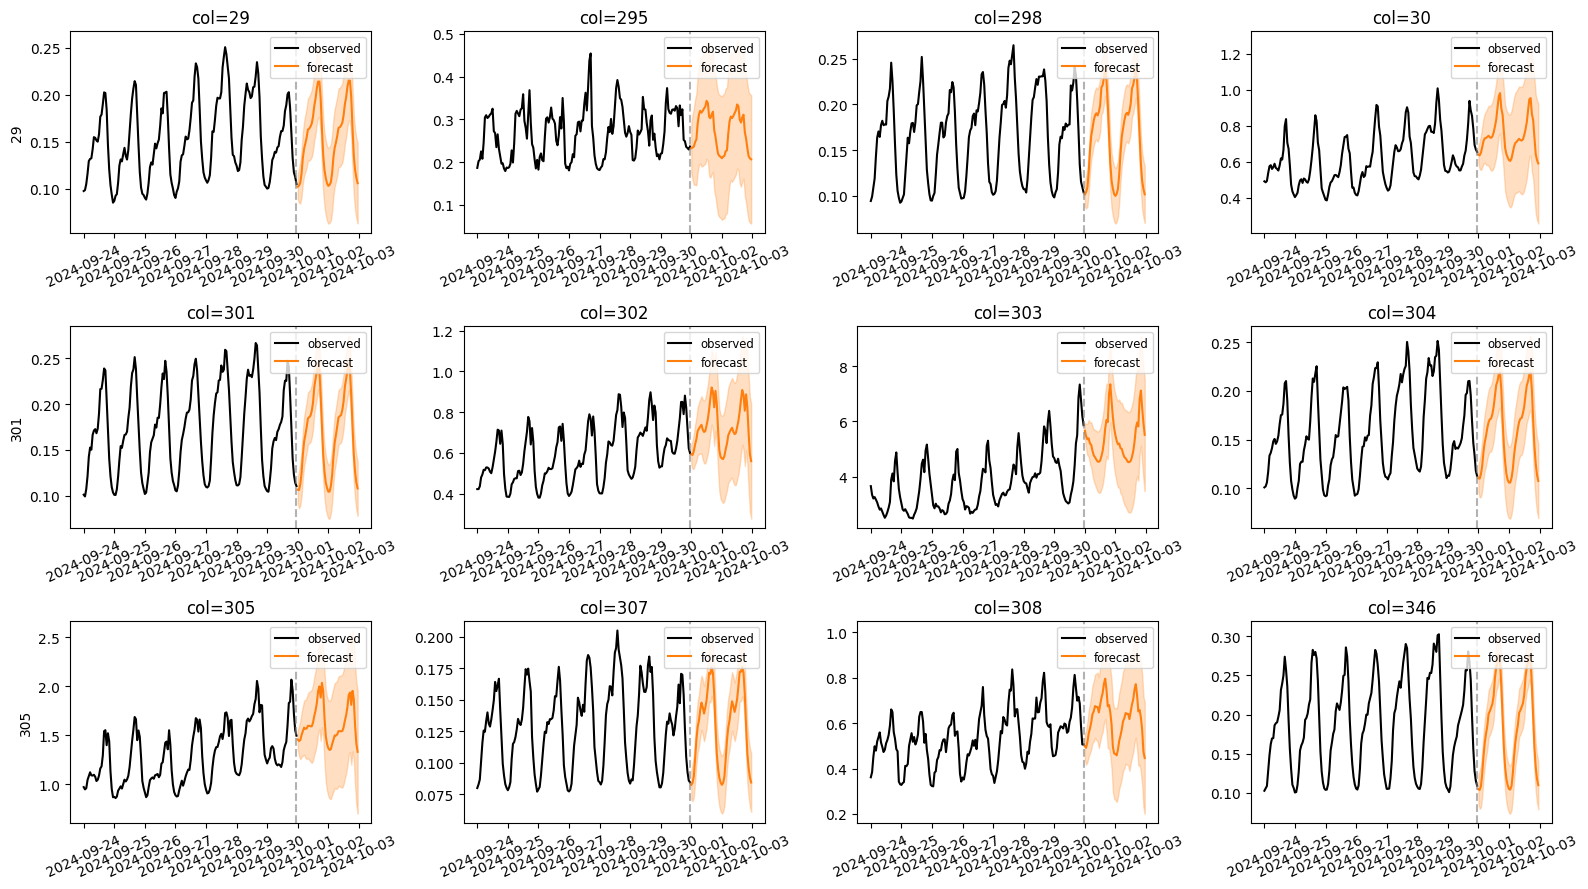

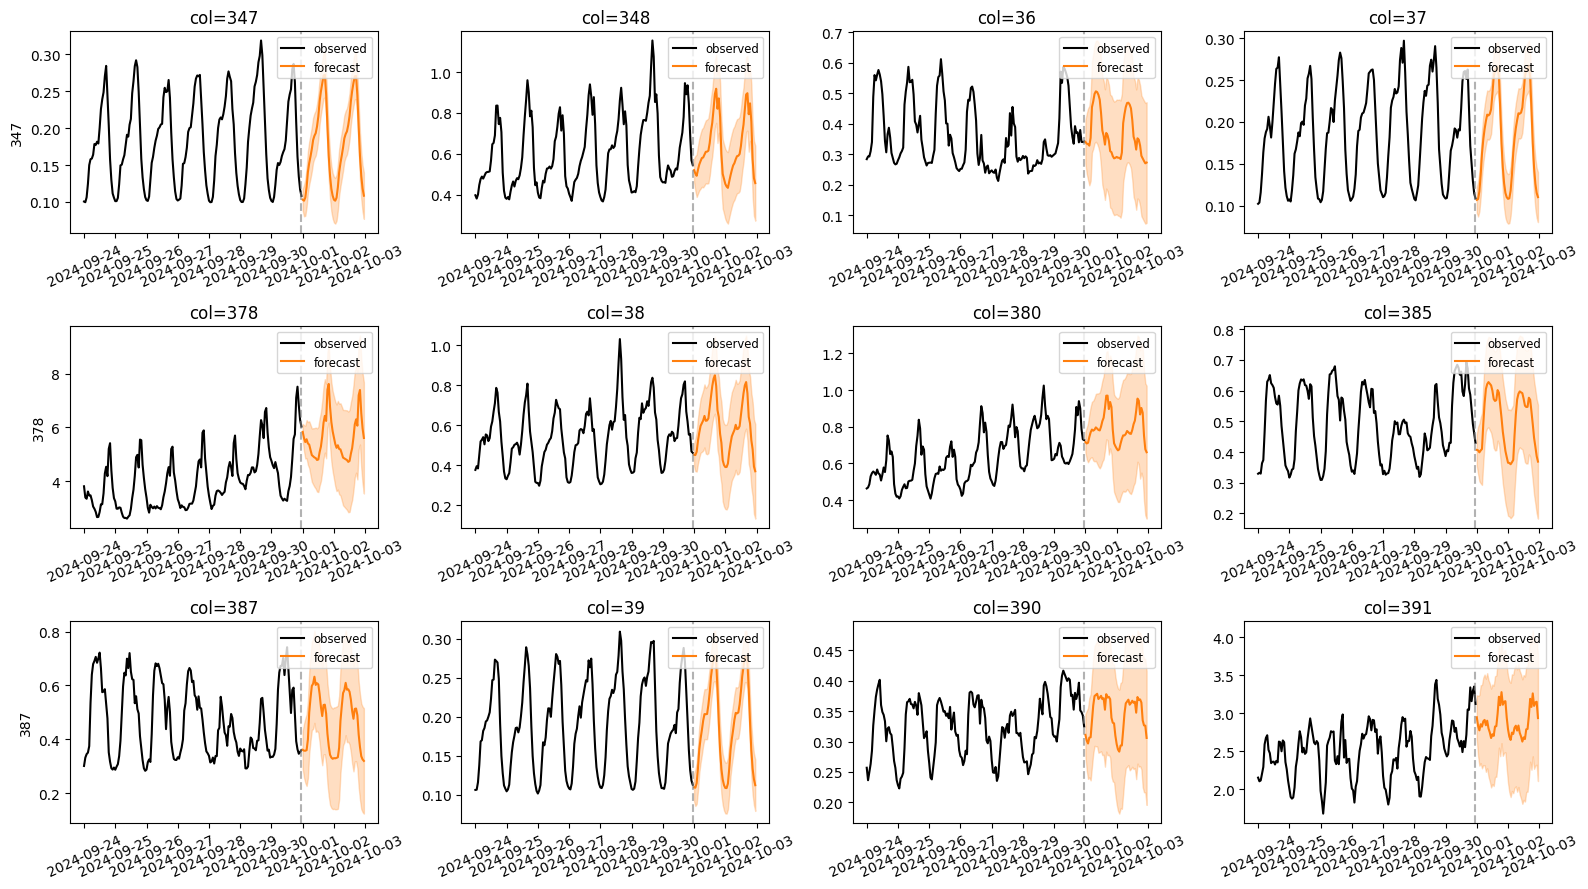

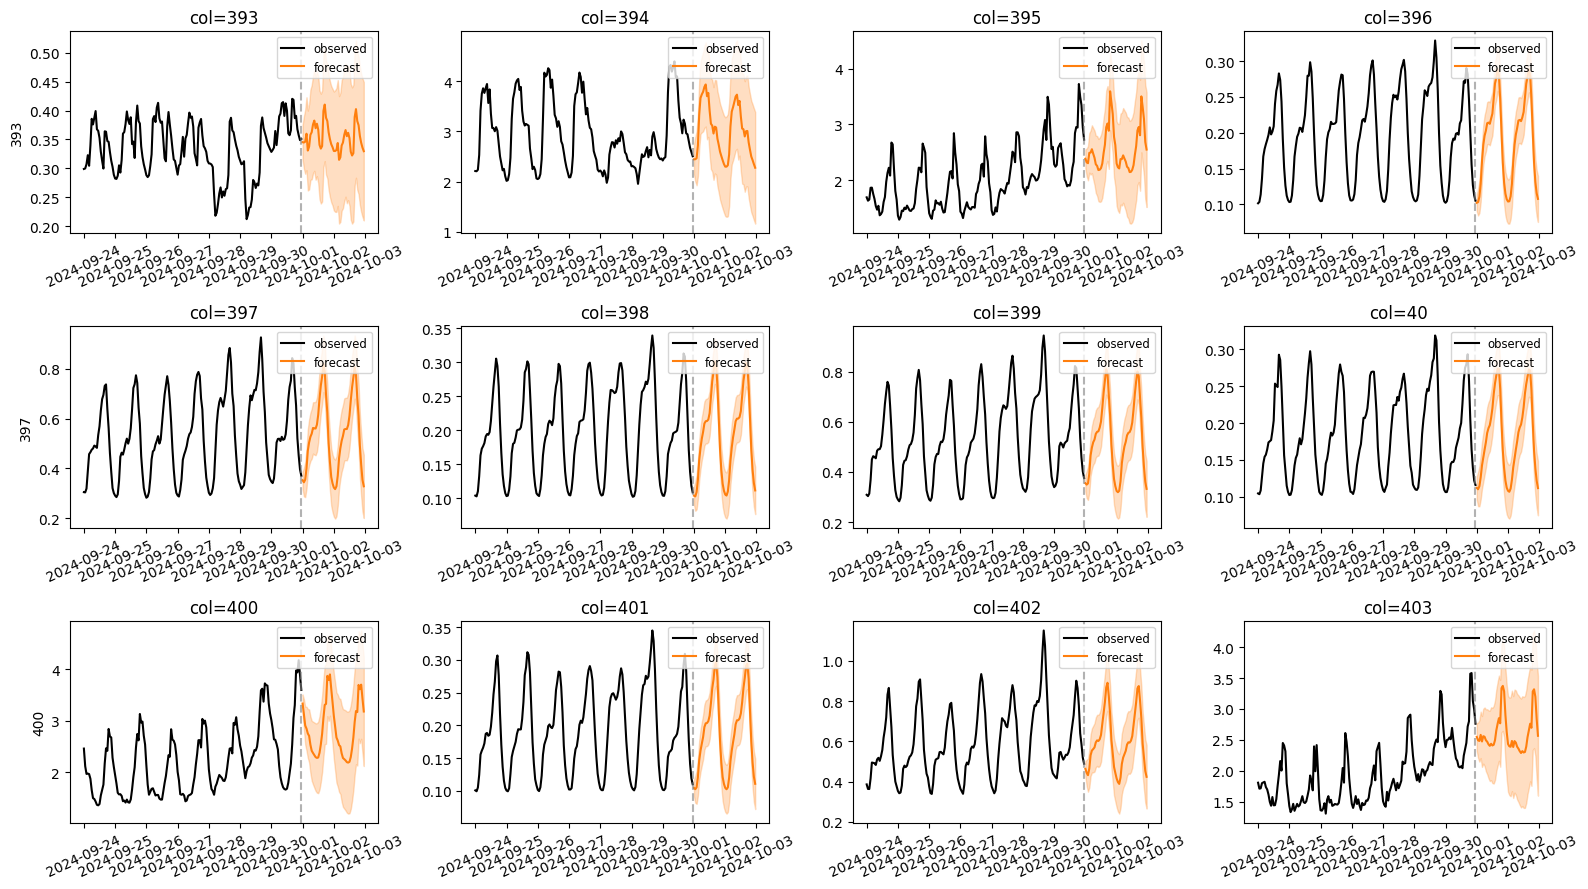

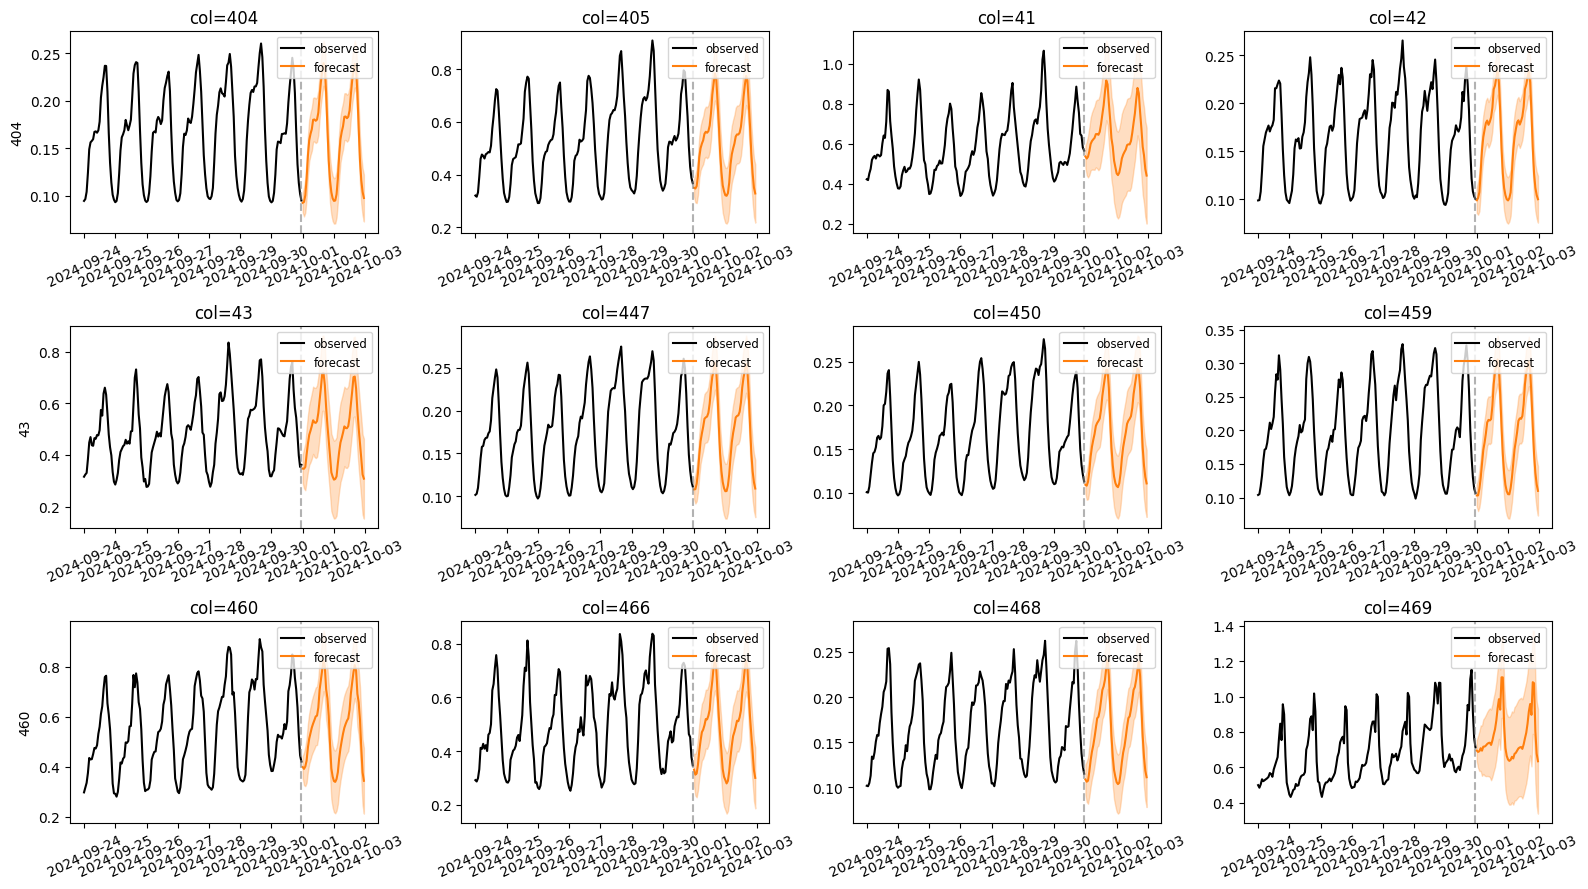

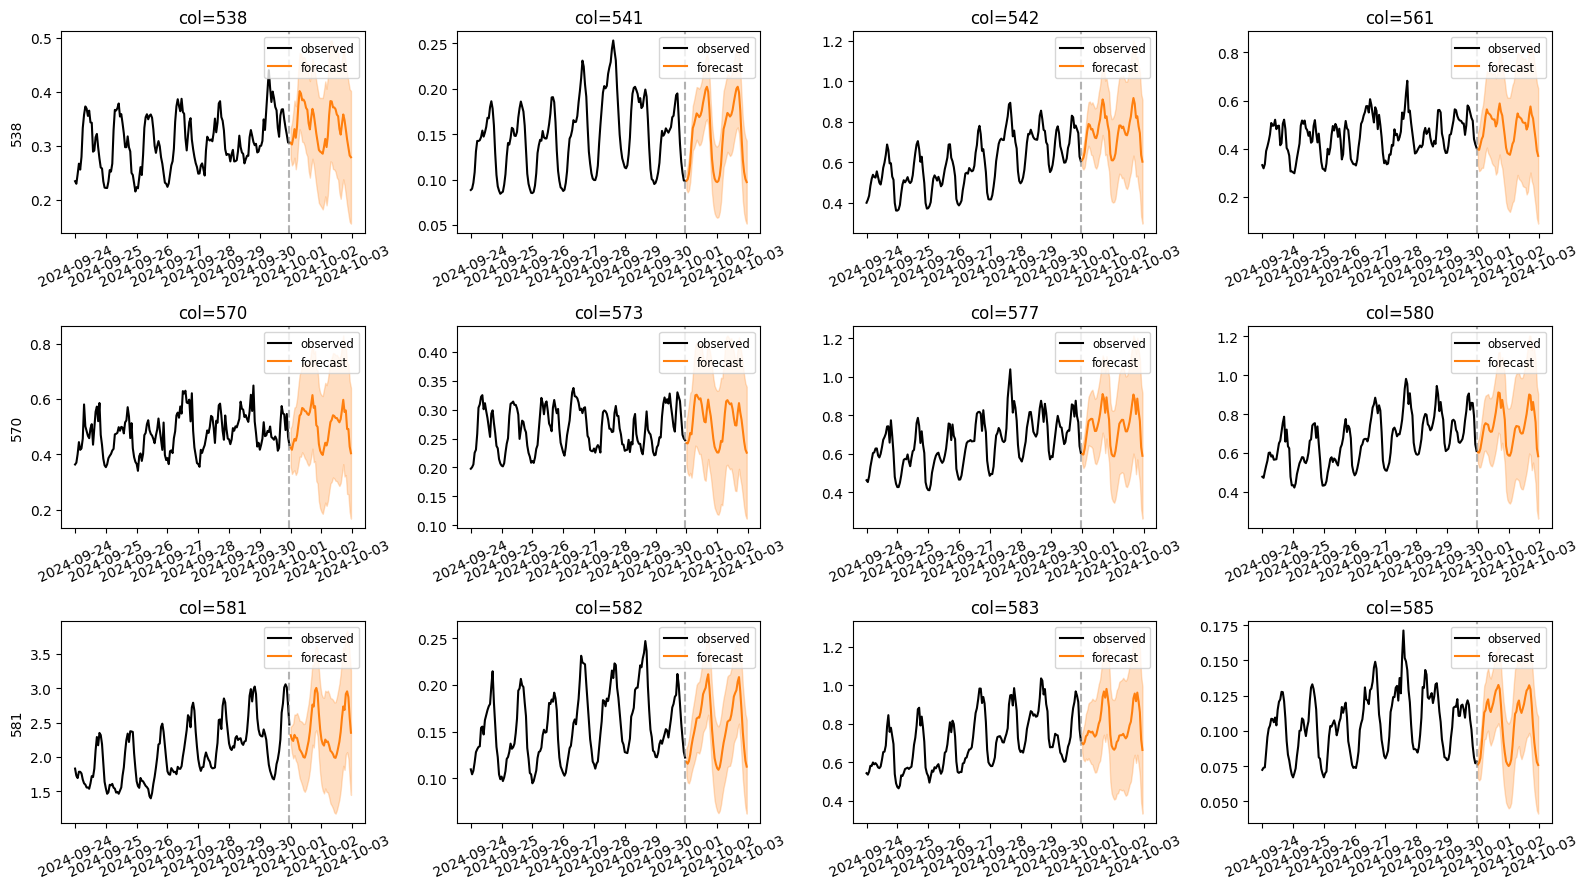

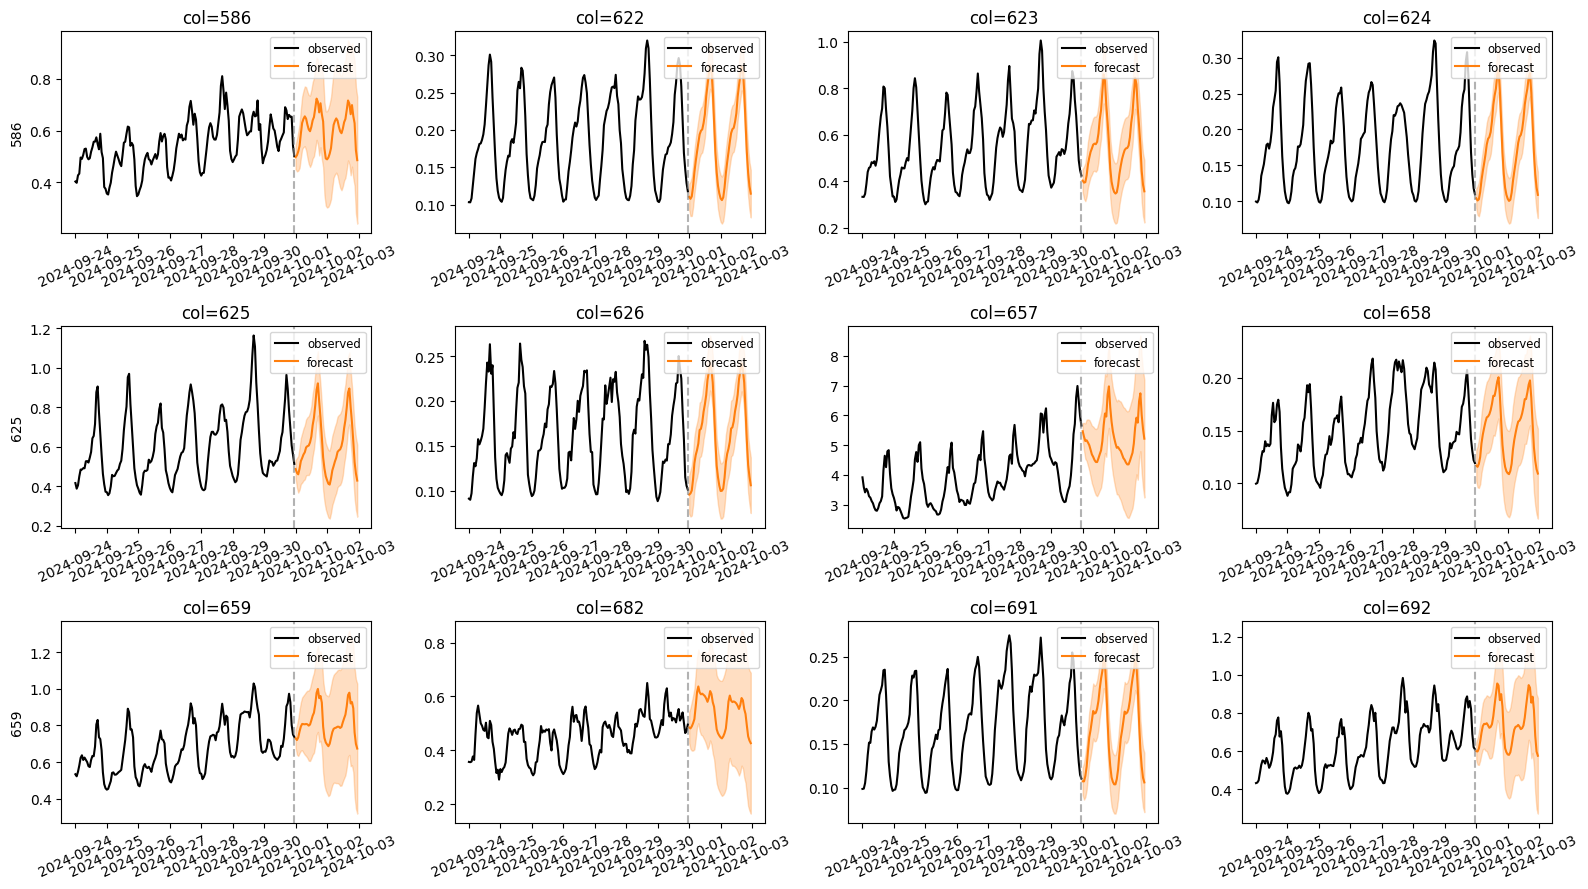

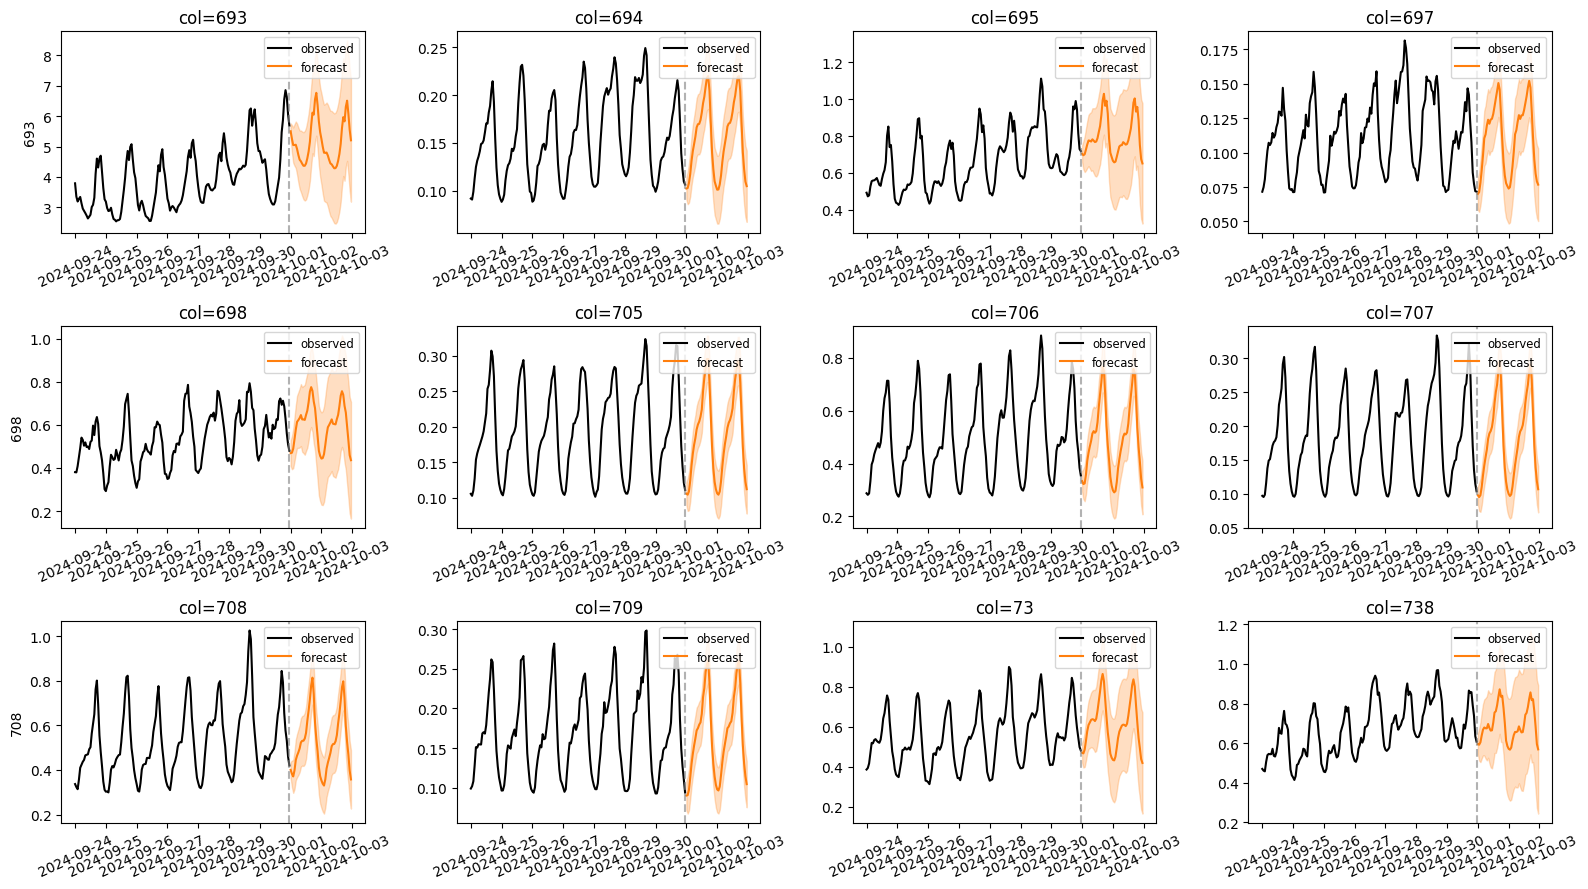

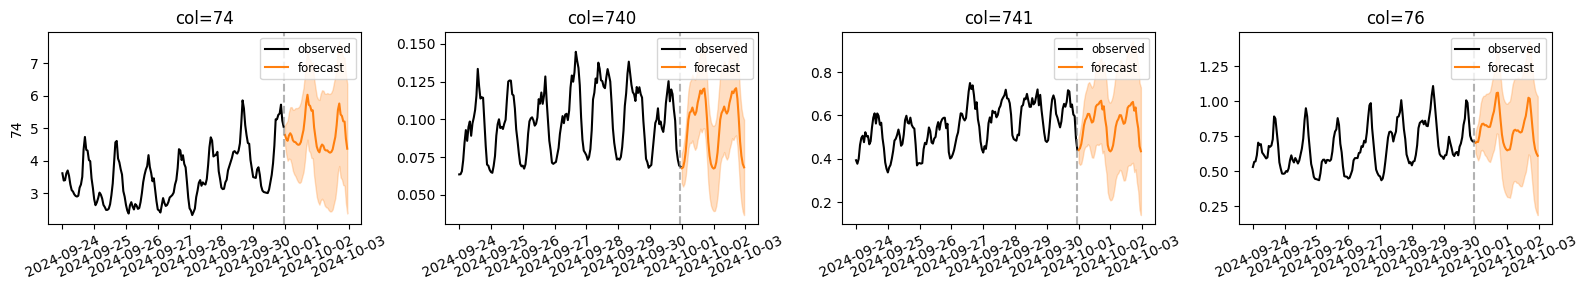

Saved forecasts for 112 columns in `all_forecasts` and fitted results in `all_results`.


In [ ]:
from joblib import Parallel, delayed
import warnings, math

# Jupyter cell: SARIMA forecast for a single column (48 hours ahead)
# Assumptions and how to change them:
# - The input data variable `data` (a pandas.DataFrame) already exists in the notebook.
# - The dataframe index is a timezone-aware DatetimeIndex with hourly spacing (if not, we try to infer hourly).
#     * To change frequency assumption, set `freq='H'` in `forecast_series(...)` or pass an explicit `start_freq`.
# - We model one column (by name or numeric label). Change `col` argument to pick a different column.
# - The default (p,d,q) and seasonal (P,D,Q,s) orders are user-configurable. Default seasonal period s=24 (daily seasonality).
#     * To change seasonality, set seasonal_order or s (e.g., s=168 for weekly seasonality on hourly data).
# - No automatic order selection by default (to keep runtime predictable). A small grid-search helper is provided but limited.
#     * To enable exhaustive search, call `grid_search_sarima(...)` but be aware of runtime cost.

# NOTE: do not re-import libraries already loaded in the notebook (pandas, numpy, SARIMAX, matplotlib.pyplot).

def prepare_series(dataframe, col):
    """Return a cleaned pandas.Series for the requested column.
    Accepts column key (exact name) or integer numeric column label.
    """
    if col not in dataframe.columns:
        # if columns are integers but user passed a string or vice-versa, try converting
        try:
            alt = int(col)
            if alt in dataframe.columns:
                col = alt
        except Exception:
            pass
    if col not in dataframe.columns:
        raise KeyError(f"Column {col} not found in dataframe. Available columns: {list(dataframe.columns[:10])} ...")
    s = dataframe[col].dropna().astype(float)
    # ensure datetime index sorted
    s = s.sort_index()
    return s

def infer_hourly_freq(series):
    """Return a pandas frequency string. Default to 'H' if inference fails."""
    if getattr(series.index, "freq", None) is not None:
        return series.index.freqstr
    try:
        inferred = pd.infer_freq(series.index)
        return inferred if inferred is not None else "H"
    except Exception:
        return "H"

def fit_sarima_model(series, order=(1,0,1), seasonal_order=(1,1,1,24),
                     enforce_stationarity=False, enforce_invertibility=False, disp=False):
    """Fit SARIMAX model to a 1-d pandas Series and return the results object."""
    # statsmodels expects endog as a 1-d array-like with datetime index
    model = SARIMAX(series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=enforce_stationarity,
                    enforce_invertibility=enforce_invertibility)
    res = model.fit(disp=disp)
    return res

def forecast_series(series, results, steps=48, freq=None, plot=True, plot_last_n=7*24):
    """Produce forecast DataFrame with mean and confidence intervals for `steps` ahead.
    - freq: optional frequency string (e.g., 'H'). If None, inferred from series.
    - plot: if True, plot last observed points and forecast with CI.
    - plot_last_n: number of historical points to display on the plot.
    """
    # determine freq and forecast index
    if freq is None:
        freq = infer_hourly_freq(series)
    last_ts = series.index[-1]
    # build forecast index starting one step after last observed timestamp
    try:
        start = last_ts + pd.tseries.frequencies.to_offset(freq)
    except Exception:
        # fallback to +1 hour
        start = last_ts + pd.Timedelta(hours=1)
        freq = "H"
    fc_index = pd.date_range(start=start, periods=steps, freq=freq, tz=series.index.tz)
    # get forecast and conf int
    pred = results.get_forecast(steps=steps)
    mean = pred.predicted_mean
    ci = pred.conf_int(alpha=0.05)  # 95% CI
    # ensure index alignment
    mean.index = fc_index
    ci.index = fc_index
    forecast_df = pd.DataFrame({
        "mean": mean,
        "lower_95": ci.iloc[:, 0],
        "upper_95": ci.iloc[:, 1],
    }, index=fc_index)
    if plot:
        # prepare plot window (last historical points + forecast)
        h = min(len(series), plot_last_n)
        plt.figure(figsize=(12, 4))
        plt.plot(series.index[-h:], series.values[-h:], label="observed", color="black")
        plt.plot(forecast_df.index, forecast_df["mean"], label="forecast", color="tab:orange")
        plt.fill_between(forecast_df.index, forecast_df["lower_95"], forecast_df["upper_95"],
                         color="tab:orange", alpha=0.25, label="95% CI")
        plt.axvline(series.index[-1], color="grey", linestyle="--", alpha=0.6)
        plt.ylabel(series.name if series.name is not None else "value")
        plt.legend()
        plt.tight_layout()
        plt.show()
    return forecast_df

def grid_search_sarima(series, pdq_range=[0,1], seasonal_pdq_range=[0,1],
                       d=0, D=0, s=24, max_models=20):
    """Simple limited grid search over small orders to find low-AIC model.
    - pdq_range: list or iterable of p and q values to try (d is fixed).
    - seasonal_pdq_range: list or iterable of P and Q values to try (D is fixed).
    - s: seasonal period (e.g., 24 for daily seasonality on hourly data).
    - max_models: stop after trying this many models to limit runtime.
    Returns: (best_result, best_order, best_seasonal_order, tried_models_list)
    NOTE: This is intentionally conservative to avoid long runtimes. Expand ranges at your own risk.
    """
    best_aic = np.inf
    best_res = None
    tried = []
    tried_count = 0
    for p in pdq_range:
        for q in pdq_range:
            for P in seasonal_pdq_range:
                for Q in seasonal_pdq_range:
                    if tried_count >= max_models:
                        break
                    order = (p, d, q)
                    seasonal_order = (P, D, Q, s)
                    try:
                        res = fit_sarima_model(series, order=order, seasonal_order=seasonal_order,
                                               enforce_stationarity=False, enforce_invertibility=False, disp=False)
                        tried.append((order, seasonal_order, res.aic))
                        if res.aic < best_aic:
                            best_aic = res.aic
                            best_res = res
                            best_order = order
                            best_seasonal_order = seasonal_order
                    except Exception:
                        # skip models that fail to converge or raise errors
                        pass
                    tried_count += 1
                if tried_count >= max_models:
                    break
            if tried_count >= max_models:
                break
        if tried_count >= max_models:
            break
    if best_res is None:
        raise RuntimeError("Grid search failed to fit any model. Try different ranges or initial orders.")
    return best_res, best_order, best_seasonal_order, tried

# Example usage in this notebook (adjust parameters as needed):
# Select a column to model (change to any column available in `data`)
# train & forecast all columns in parallel (CPU). Note: statsmodels SARIMAX does not support GPU;
# true GPU training for SARIMA isn't available with statsmodels. We parallelize across CPU cores instead.

warnings.filterwarnings("ignore")  # reduce noise from failed fits

def _fit_and_forecast_col(col, order=(1,0,1), seasonal_order=(1,1,1,24), steps=48):
    """Fit SARIMA for one column and return dict with series, result and forecast or error info."""
    try:
        s = prepare_series(data, col)
        # If data is too short for the seasonal period, disable seasonality to avoid model failures.
        if len(s) < max(2, 2 * seasonal_order[3]):
            seasonal_order = (1, 1, 1, 24)
        res = fit_sarima_model(s,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp=False)
        fc = forecast_series(s, res, steps=steps, freq=None, plot=False)
        return {"col": col, "series": s, "result": res, "forecast": fc}
    except Exception as e:
        return {"col": col, "error": str(e)}

# list of columns to model
cols_to_model = list(data.columns)

print(f"Running SARIMA fits in parallel on {len(cols_to_model)} columns using all CPU cores (n_jobs=-1).")
print("Reminder: statsmodels SARIMAX does not use GPU. If you require GPU-accelerated time series models, consider deep-learning alternatives (Prophet/ARIMA variants generally CPU).")

# run fits in parallel (uses all CPU cores). This may still take a long time depending on data/model.
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(_fit_and_forecast_col)(c) for c in cols_to_model
)

# organize successful and failed fits
successful = {r["col"]: r for r in results if r and "forecast" in r}
failed = {r["col"]: r for r in results if r and "error" in r}

print(f"Fitted: {len(successful)} models, Failed: {len(failed)} models")

# Plot forecasts for all successful models in pages to avoid huge single figure.
# Configure plots per page
max_plots_per_page = 12
n_success = len(successful)
if n_success == 0:
    print("No successful fits to plot.")
else:
    cols_sorted = sorted(successful.keys(), key=lambda x: str(x))
    for start in range(0, n_success, max_plots_per_page):
        page_cols = cols_sorted[start:start + max_plots_per_page]
        n_plots = len(page_cols)
        ncols = 4
        nrows = math.ceil(n_plots / ncols)
        plt.figure(figsize=(4 * ncols, 3 * nrows))
        for i, col in enumerate(page_cols, 1):
            rec = successful[col]
            s = rec["series"]
            fc = rec["forecast"]
            ax = plt.subplot(nrows, ncols, i)
            h = min(len(s), 7*24)  # last 7 days
            ax.plot(s.index[-h:], s.values[-h:], color="black", label="observed")
            ax.plot(fc.index, fc["mean"], color="tab:orange", label="forecast")
            ax.fill_between(fc.index, fc["lower_95"], fc["upper_95"], color="tab:orange", alpha=0.25)
            ax.axvline(s.index[-1], color="grey", linestyle="--", alpha=0.6)
            ax.set_title(f"col={col}")
            if i % ncols == 1:
                ax.set_ylabel(s.name if s.name is not None else "value")
            ax.tick_params(axis='x', rotation=25)
            ax.legend(loc="upper right", fontsize="small")
        plt.tight_layout()
        plt.show()

# Save the forecasts/results into dictionaries for later use
all_forecasts = {col: rec["forecast"] for col, rec in successful.items()}
all_results = {col: rec.get("result") for col, rec in successful.items()}

# quick summary
print(f"Saved forecasts for {len(all_forecasts)} columns in `all_forecasts` and fitted results in `all_results`.")
if failed:
    print("Example failures (first 5):")
    for k, v in list(failed.items())[:5]:
        print(k, "->", v["error"])

# The returned forecast_df contains columns: mean, lower_95, upper_95 indexed by forecast timestamps.
# You can change:
# - `column_to_model` to forecast a different column.
# - `order` and `seasonal_order` to different SARIMA parameters.
# - `s` in seasonal_order to change seasonal period (e.g., 168 for weekly seasonality with hourly data).
# - `steps` to change forecast horizon.
# - Use `grid_search_sarima(...)` to attempt automated order selection (but this increases runtime).

In [ ]:
import io

def extract_all_data_points(data_dict):
    """
    Analyzes a dictionary of category IDs mapped to pandas DataFrames.
    For each category, it extracts all 'mean' values and their
    corresponding timestamps.

    Args:
        data_dict (dict): A dictionary where keys are category IDs and
                          values are pandas DataFrames with a datetime index
                          and a 'mean' column.

    Returns:
        dict: A dictionary where keys are category IDs and values are a list
              of dictionaries, each containing {'timestamp': datetime_str, 'mean': value}.
    """

    results = {}

    # Iterate through each category and its associated DataFrame
    for category_id, df in data_dict.items():
        # Ensure the 'mean' column exists
        if 'mean' in df.columns:
            category_data = []

            # Iterate over the index (timestamp) and 'mean' value pairs
            for timestamp, mean_value in df['mean'].items():
                category_data.append({
                    # Convert timestamp to a standardized string format
                    'timestamp': str(timestamp),
                    'mean': mean_value
                })

            # Store the list of all timestamp-mean pairs for the category
            results[category_id] = category_data
        else:
            print(f"Warning: Category {category_id} DataFrame is missing the 'mean' column.")

    return results

# --- 2. EXECUTE AND PRINT RESULTS ---
all_results2 = extract_all_data_points(all_forecasts)

print("--- Results: Full List of Mean Values and Timestamps per Category ---")
for category, results_list in all_results2.items():
    print(f"\nCategory {category} ({len(results_list)} data points):")
    # Print the first few results to demonstrate the structure
    for item in results_list:
        print(f"  Timestamp: {item['timestamp']} | Mean: {item['mean']:.6f}")

--- Results: Full List of Mean Values and Timestamps per Category ---

Category 28 (48 data points):
  Timestamp: 2024-10-01 00:00:00+00:00 | Mean: 4.803362
  Timestamp: 2024-10-01 01:00:00+00:00 | Mean: 4.697626
  Timestamp: 2024-10-01 02:00:00+00:00 | Mean: 4.655386
  Timestamp: 2024-10-01 03:00:00+00:00 | Mean: 4.836949
  Timestamp: 2024-10-01 04:00:00+00:00 | Mean: 4.893217
  Timestamp: 2024-10-01 05:00:00+00:00 | Mean: 4.825414
  Timestamp: 2024-10-01 06:00:00+00:00 | Mean: 4.735401
  Timestamp: 2024-10-01 07:00:00+00:00 | Mean: 4.662078
  Timestamp: 2024-10-01 08:00:00+00:00 | Mean: 4.605618
  Timestamp: 2024-10-01 09:00:00+00:00 | Mean: 4.502037
  Timestamp: 2024-10-01 10:00:00+00:00 | Mean: 4.461836
  Timestamp: 2024-10-01 11:00:00+00:00 | Mean: 4.444877
  Timestamp: 2024-10-01 12:00:00+00:00 | Mean: 4.485116
  Timestamp: 2024-10-01 13:00:00+00:00 | Mean: 4.676581
  Timestamp: 2024-10-01 14:00:00+00:00 | Mean: 4.865338
  Timestamp: 2024-10-01 15:00:00+00:00 | Mean: 5.252396
  T

In [ ]:
def create_excel_ready_dataframe(data_dict, filename="category_means.xlsx"):
    """
    Restructures the dictionary of DataFrames into a single DataFrame where
    the index is the timestamp and columns are the category IDs containing
    the 'mean' values.

    This function simulates writing the result to an Excel file.

    Args:
        data_dict (dict): A dictionary where keys are category IDs and
                          values are pandas DataFrames.
        filename (str): The name of the Excel file to generate.

    Returns:
        pd.DataFrame: The restructured DataFrame ready for export.
    """

    mean_series_to_concat = {}

     # 1. Iterate through each DataFrame (df) in the input dictionary.
    for category_id, df in data_dict.items():

        # Create a copy to ensure we don't modify the original data source
        df_processed = df.copy()

        # --- ROBUST FIX: Handle Timezone on Index ---
        if isinstance(df_processed.index, pd.DatetimeIndex) and df_processed.index.tz is not None:
            # Convert to UTC and strip timezone info
            df_processed.index = df_processed.index.tz_convert('UTC').tz_localize(None)

        # --- NEW ROBUST FIX: Handle Timezone on Columns ---
        # Look for columns that are timezone-aware datetime objects (datetimetz)
        datetimetz_cols = df_processed.select_dtypes(include=['datetimetz']).columns

        if not datetimetz_cols.empty:
            print(f"Applying timezone strip to columns: {list(datetimetz_cols)} in Category {category_id}")
            for col in datetimetz_cols:
                # Convert the column to UTC and strip timezone info
                df_processed[col] = df_processed[col].dt.tz_convert('UTC').dt.tz_localize(None)

        # 2. Extract the 'mean' column from the processed DataFrame
        if 'mean' in df_processed.columns:
            # Select the 'mean' column and rename the resulting Series to the category ID
            mean_series = df_processed['mean'].rename(category_id)
            mean_series_to_concat[category_id] = mean_series
        else:
            print(f"Warning: Category {category_id} DataFrame is missing the 'mean' column and will be skipped.")

    # 3. Concatenate all Series along the column axis (axis=1).
    final_df = pd.concat(mean_series_to_concat, axis=1)

    # 4. Write the DataFrame to an Excel file (simulated)
    # If the user were running this locally, this is where to_excel would go:
    final_df.to_excel(filename, index=True, header=True, sheet_name='Category Means')

    return final_df

# --- 2. EXECUTE AND PRINT RESULTS ---
excel_df = create_excel_ready_dataframe(all_forecasts)

print("--- Restructured DataFrame (Excel Output Preview) ---")
# The index (timestamps) becomes the first column in the Excel output
print(excel_df.to_string())

# Note: If you were running this script locally, uncommenting the lines inside
# the function would create an actual 'category_means.xlsx' file

--- Restructured DataFrame (Excel Output Preview) ---
                          28        29        30        36        37        38        39        40        41        42        43        73        74        76        116       149       150       151       152       157       196       197       198       199       200       201       213       222       225       231       233       234       235       237       238       270       271       295       298       301       302       303       304       305       307       308       346       347       348       378       380       385       387       390       391       393       394       395       396       397       398       399       400       401       402       403       404       405       447       450       459       460       466       468       469       538       541       542       561       570       573       577       580       581       582       583       585       586       622       623       624       625       

In [ ]:
excel_df.index.name = 'measured_at'
# Step 1: Format the index to ISO 8601 string format
# This creates a new index with string representations of the timestamps
excel_df.index = excel_df.index.strftime('%Y-%m-%dT%H:%M:%S.000Z')
# Convert the DataFrame to CSV content (simulating file output)
csv_buffer = io.StringIO()
# index=True ensures the Timestamp index is written as the first column
excel_df.to_csv(csv_buffer, index=True, header=True, sep=';', decimal=',')
csv_content = csv_buffer.getvalue()

print("--- Restructured DataFrame (Excel Output Preview) ---")
print(excel_df.to_string())

print("\n--- Converted CSV File Content ---")
print(csv_content)

--- Restructured DataFrame (Excel Output Preview) ---
                               28        29        30        36        37        38        39        40        41        42        43        73        74        76        116       149       150       151       152       157       196       197       198       199       200       201       213       222       225       231       233       234       235       237       238       270       271       295       298       301       302       303       304       305       307       308       346       347       348       378       380       385       387       390       391       393       394       395       396       397       398       399       400       401       402       403       404       405       447       450       459       460       466       468       469       538       541       542       561       570       573       577       580       581       582       583       585       586       622       623       624       625  

In [ ]:
from google.colab import files
# --- New code for downloading the CSV file ---
# Step 1: Define the filename for your CSV
csv_filename = 'forecast_output.csv'

# Step 2: Write the csv_content to a file
with open(csv_filename, 'w') as f:
    f.write(csv_content)

# Step 3: Trigger the download
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>